In [1]:
# Import packages
import plotly.express as px
import pandas as pd

# Read in the data
data = pd.read_csv('AirPassengers.csv')
data['Month'] = pd.to_datetime(data['Month'])


def plot_passenger_volumes(df: pd.DataFrame,
                           y: str) -> None:
    """General function to plot the passenger data."""

    fig = px.line(df, x='Month', y=y, labels={'Month': 'Date'})
    fig.update_layout(template="simple_white", font=dict(size=18), title_text='Airline Passengers',
                      width=650, title_x=0.5, height=400)

    return fig.show()


# Plot the airline passenger data
plot_passenger_volumes(df=data, y='#Passengers')

In [2]:
# Import packages
from scipy.stats import boxcox

# Make the target variance stationary
data['Passengers_Boxcox'], lam = boxcox(data['#Passengers'])

# Plot the box-cox passenger data
plot_passenger_volumes(df=data, y='Passengers_Boxcox')

Box-Cox 变换的作用
Box-Cox 变换主要用于：

稳定方差：使数据的方差不随时间变化
正态化：使数据分布更接近正态分布
线性化：改善数据与预测变量之间的线性关系

在时间序列分析中，方差平稳性尤为重要，因为许多模型（如 ARIMA）假设数据是平稳的，包括均值平稳和方差平稳。

### Modelling

In the previous sections, I mentioned how you can find the autoregressive and moving-average orders by plotting the autocorrelation and partial autocorrelation functions. Let’s show an example of how you can do it here:

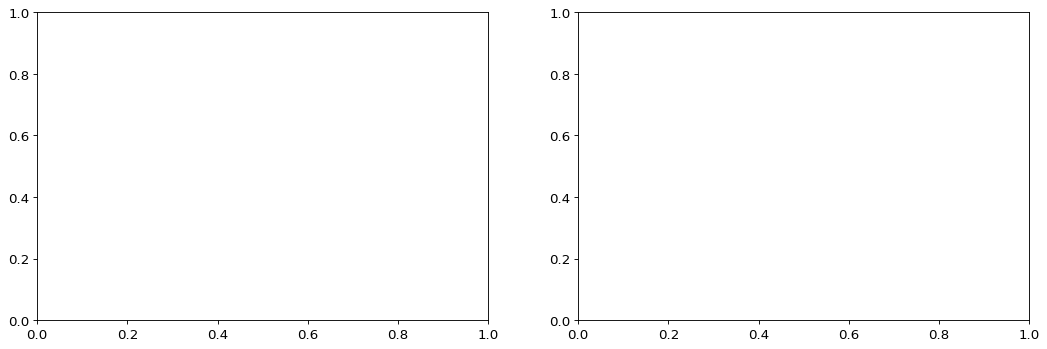

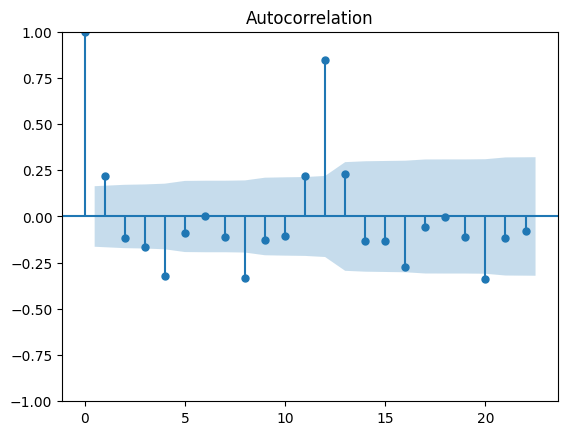

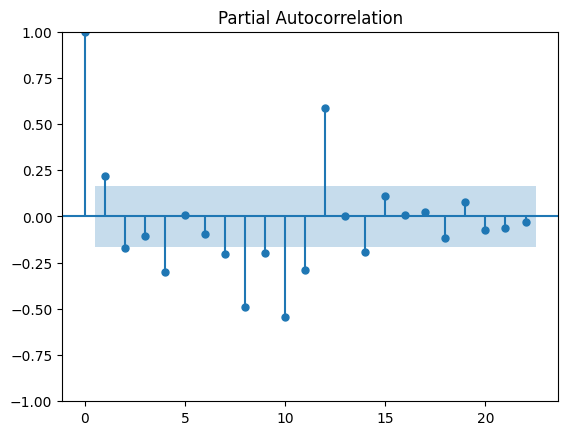

In [3]:
# Import packages
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

# Difference the data
data["Passenger_diff"] = data["Passengers_Boxcox"].diff()
data.dropna(inplace=True)

# Plot acf and pacf
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5), dpi=80)
plot_acf(data['Passenger_diff'])
plot_pacf(data['Passenger_diff'], method='ywm')
ax1.tick_params(axis='both', labelsize=12)
ax2.tick_params(axis='both', labelsize=12)
plt.show()

The blue region signifies where the points are no longer statistically significant and from the plot we see the last lag that is statistically significant for both plot is ~12th. Therefore, we would take the order of p and q to be 12.

Now, let’s fit the model using the ARIMA function and generate the forecasts:

In [4]:
# Import packages
from statsmodels.tsa.arima.model import ARIMA
from scipy.special import inv_boxcox

# Split train and test
train = data.iloc[:-int(len(data) * 0.2)]
test = data.iloc[-int(len(data) * 0.2):]

# Build ARIMA model and inverse the boxcox
model = ARIMA(train['Passengers_Boxcox'], order=(12, 1, 12)).fit()
boxcox_forecasts = model.forecast(len(test))
forecasts = inv_boxcox(boxcox_forecasts, lam)

D:\conda\envs\timing_algorithm\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.

D:\conda\envs\timing_algorithm\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.

D:\conda\envs\timing_algorithm\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.

D:\conda\envs\timing_algorithm\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

D:\conda\envs\timing

### Results

The forecasts produced from this fitted model is for the differenced and Box-Cox transformed time series that we produced earlier. Therefore, we have to un-difference and apply the inverse Box-Cox transform to the predictions to acquire the actual airline passenger forecasted volumes:

In [5]:
# Import packages
import plotly.graph_objects as go

def plot_forecasts(forecasts: list[float], title: str) -> None:
    """Function to plot the forecasts."""
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=train['Month'], y=train['#Passengers'], name='Train'))
    fig.add_trace(go.Scatter(x=test['Month'], y=test['#Passengers'], name='Test'))
    fig.add_trace(go.Scatter(x=test['Month'], y=forecasts, name='Forecast'))
    fig.update_layout(template="simple_white", font=dict(size=18), title_text=title,
                      width=650, title_x=0.5, height=400, xaxis_title='Date',
                      yaxis_title='Passenger Volume')

    return fig.show()


# Plot the forecasts
plot_forecasts(forecasts, 'ARIMA')